In [ ]:
!pip install d2l==0.14.2

3.1.2 Vectorization for Speed

In [ ]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l



In [ ]:
n=10000
a=torch.ones(n)
b=torch.ones(n)

In [ ]:
class Timer: #@save
    """Record multiple runiing times."""
    def __init__(self):
        self.times=[]
        self.start()
        
    def start(self):
        """Start the timer."""
        self.tik=time.time()
        
    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time()-self.tik)
        return self.times[-1]
    
    def avg(self):
        """Return the average time."""
        return sum(self.times)/len(self.times)
    
    def sum(self):
        """Return the sum of time."""
        return sum(self.times)
    
    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [ ]:
c=torch.zeros(n)
timer=Timer()
for i in range(n):
  c[i]=a[i]+b[i]
f'{timer.stop():.5f}sec'

'0.08059sec'

In [ ]:
timer.start()
d=a+b
f'{timer.stop():.5f}sec'

'0.00048sec'

3.1.3 The Normal Distribution and Squared Loss

In [ ]:
def normal(x, mu, sigma):
  p=1/math.sqrt(2*math.pi*sigma**2)
  return p*np.exp(-0.5/sigma**2*(x-mu)**2)

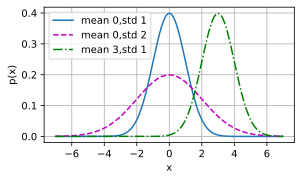

In [ ]:
#Use numpy again for visualization
x=np.arange(-7, 7, 0.01)

#Mean and standard deviation pairs
params=[(0,1),(0,2),(3,1)]
d2l.plot(x,[normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu},std {sigma}' for mu, sigma in params])

3.2 Linear Regression Implementation from Scratch

3.2.1 Generating the Dataset

In [ ]:
def synthetic_data(w, b, num_examples):
  """Generate y = Xw + b +noise."""
  X = torch.normal(0,1, (num_examples, len(w)))
  y= torch.matmul(X, w)+b
  y+= torch.normal(0, 0.01, y.shape)
  return X, y.reshape((-1,1))

In [ ]:
true_w=torch.tensor([2, -3.4])
true_b=4.2
features, labels=synthetic_data(true_w, true_b, 1000)
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([ 1.5680, -1.3247]) 
label: tensor([11.8302])


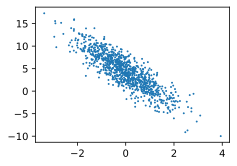

In [ ]:
d2l.set_figsize()
#The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(),1);

3.2.2 Reading the Dataset

In [ ]:
import random

def data_iter(batch_size, features, labels):
  num_examples=len(features)
  indices= list(range(num_examples))
  #The examples are read at random, in no particular order
  random.shuffle(indices)
  for i in range(0, num_examples, batch_size):
    batch_indices=torch.tensor(
        indices[i: min(i+batch_size, num_examples)])
    yield features[batch_indices], labels[batch_indices]

In [ ]:
batch_size=10

for X, y in data_iter(batch_size, features, labels):
  print(X, '\n', y)
  break

tensor([[-0.7490,  0.0639],
        [ 0.5934, -0.1203],
        [ 1.5277,  0.7229],
        [-0.4390, -0.1874],
        [-0.3411,  0.9595],
        [-0.1059,  0.0113],
        [ 0.7201,  0.1761],
        [ 1.1898, -0.4357],
        [ 0.0980,  0.9540],
        [-0.8346,  0.8126]]) 
 tensor([[ 2.4922],
        [ 5.8101],
        [ 4.8013],
        [ 3.9638],
        [ 0.2496],
        [ 3.9477],
        [ 5.0406],
        [ 8.0507],
        [ 1.1474],
        [-0.2263]])


In [ ]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b= torch.zeros(1, requires_grad=True)

3.2.4 Defining the Model

In [ ]:
def linreg(X, w, b):
  """The linear regression model."""
  return torch.matmul(X, w)+b

3.2.5 Defining the Loss Function

In [ ]:
def squared_loss(y_hat, y):
  """Squared loss."""
  return (y_hat - y.reshape(y_hat.shape))**2 / 2

3.2.6 Defining the Optimization Algorithm

In [ ]:
def sgd(params, lr, batch_size):
  """Minibatch stochastic gradient descent."""
  with torch.no_grad():
    for param in params:
      param -= lr * param.grad / batch_size
      param.grad.zero_()

3.2.7 Training

In [ ]:
lr=0.03
num_epochs=3
net=linreg
loss=squared_loss

In [ ]:
for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    l = loss(net(X, w, b), y)  #Minibatch loss in 'X' and 'y'
    #Compute gradient on 'l' with respect to ['w', 'b']
    l.sum().backward()
    sgd([w, b], lr, batch_size)  #Update parameters using their gradient
  with torch.no_grad():
    train_1 = loss(net(features, w, b), labels)
    print(f'epoch {epoch+1}, loss {float(train_1.mean()):f}')

epoch 1, loss 0.029170
epoch 2, loss 0.000101
epoch 3, loss 0.000048


In [ ]:
print(f'error in estimating w: {true_w -w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b -b}')

error in estimating w: tensor([-8.6069e-05, -4.2725e-04], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0004], grad_fn=<RsubBackward1>)


3.3 Concise Implementation of Linear regression

3.3.1 Generating the Dataset

In [ ]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [ ]:
true_w= torch.tensor([2, -3.4])
true_b = 4.2
features, labels= d2l.synthetic_data(true_w, true_b, 1000)

3.3.2 Reading the Dataset

In [ ]:
def load_array(data_arrays, batch_size, is_train=True):
  """Construct a PyTorch data iterator."""
  dataset = data.TensorDataset(*data_arrays)
  return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [ ]:
batch_size=10
data_iter= load_array((features, labels), batch_size)

In [ ]:
next(iter(data_iter))

[tensor([[ 0.5861,  1.8447],
         [-0.8367,  0.3385],
         [-0.1067, -0.0998],
         [ 0.1463,  0.5981],
         [-0.2019,  1.3173],
         [ 0.4007, -1.2496],
         [-0.0128, -1.2420],
         [-0.5327, -1.4789],
         [ 0.5510, -0.7618],
         [-0.0667, -0.8040]]), tensor([[-0.9079],
         [ 1.3711],
         [ 4.3149],
         [ 2.4410],
         [-0.6822],
         [ 9.2595],
         [ 8.3968],
         [ 8.1640],
         [ 7.8926],
         [ 6.8131]])]

3.3.3 Defining the Model

In [ ]:
#'nn' is an abbreviation for neural networks
from torch import nn

net=nn.Sequential(nn.Linear(2,1))

3.3.4 Initializing Model Parameters

In [ ]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

3.3.5 Defining the Loss Function

In [ ]:
loss=nn.MSELoss()

3.3.6 Defining the Optimization Algorithm

In [ ]:
trainer=torch.optim.SGD(net.parameters(), lr=0.03)

3.3.7 Training

In [ ]:
num_epochs=3
for epoch in range(num_epochs):
  for X, y in data_iter:
    l=loss(net(X), y)
    trainer.zero_grad()
    l.backward()
    trainer.step()
  l=loss(net(features), labels)
  print(f'epoch {epoch+1}, loss {l:f}')

epoch 1, loss 0.000192
epoch 2, loss 0.000105
epoch 3, loss 0.000104


In [ ]:
w=net[0].weight.data
print('error in estimating w:', true_w -w.reshape(true_w.shape))
b=net[0].bias.data
print('error in estimating b:', true_b -b)

error in estimating w: tensor([-0.0002,  0.0007])
error in estimating b: tensor([-0.0002])


3.5 The Image Classification Dataset

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

3.5.1 Reading the Dataset

In [ ]:
#'ToTensor' converts the image data from PIL type to 32-bit floating point
# tensors. It divides all numbers by 255 so that all pixel values are between 0 and 1
trans=transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [ ]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [ ]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
def get_fashion_mnist_labels(labels):
  """Return text labels for the Fashion-MNIST dataset."""
  text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return[text_labels[int(i)] for i in labels]

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  """Plot a list of images."""
  figsize = (num_cols*scale, num_rows*scale)
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
  axes=axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    if torch.is_tensor(img):
      #Tensor Image
      ax.imshow(img.numpy())
    else:
      #PIL Image
      ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles:
      ax.set_title(titles[i])
  return axes

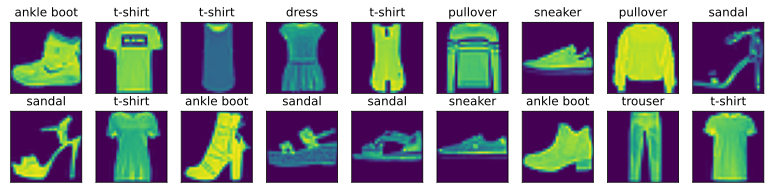

In [ ]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

3.5.2 Reading a Minibatch